# Bull Stearns: Predicting Sales Per Share

-Adam, Ari, Brandt, and Ian.

Heads up: running this notebook from top to bottom would probably take around 10ish minutes.

In [1]:
# !pip install wrds # Uncomment if in collab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set_theme()
import statsmodels.formula.api as smf
import wrds
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x);

Establish words connection in below cell which is necessary to acces the data. You will probably need to input your own username and password.

In [2]:
# db = wrds.Connection(wrds_username='arichowdhury')
# db = wrds.Connection(wrds_username='bgreen41')
db = wrds.Connection(wrds_username='iarzt')

Loading library list...
Done


Random helper funcs below:

In [3]:
def convert_to_sql(iterable):
    """Convert an iterable into a string that could be sent into an "In" statement in sql. Puts " ' " around each item and commas in between each item."""
    return f"""'{"', '".join(iterable)}'"""

def attach_info(df,link_col='gvkey',fields_to_pull=('tic','conm')):
    """This is mostly a silly function. We may not have even used it. Used to attach ticker and company name to a dataframe."""
    unique_link_records = convert_to_sql(df[link_col].unique())
    fields_to_pull = convert_to_sql(fields_to_pull)
    query_string = f"""SELECT distinct {link_col}, {fields_to_pull.replace("'",'')} from comp.funda where {link_col} in({unique_link_records})"""
    df_info = db.raw_sql(query_string)
    return df.merge(df_info,on=link_col)

## Data Adventures: 
First, query compustat for fundamental data on companies in the consumer durables sector. Consumer durables have ggroup key '2520'.

Data Source: [Compustat Daily Updates - Fundamentals Annual](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/)

In [4]:
# This cell may take 30ish seconds to run.
query_string = f"""SELECT * from comp.funda where gvkey In((SELECT gvkey from comp.co_hgic where ggroup = '2520')) and datafmt = 'STD' and datadate between '1994-12-31' and '2020-12-31' order by datadate desc"""
df_comp = db.raw_sql(query_string)
df_comp.head(3)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,prcc_f,prch_f,prcl_f,adjex_f,rank,au,auop,auopic,ceoso,cfoso
0,020204,2020-12-31,2020.00000,INDL,C,D,STD,ICON,451055305,ICONIX BRAND GROUP INC,...,1.26000,1.92000,0.50720,1.00000,1.00000,11,1,0,Y,Y
1,036349,2020-12-31,2020.00000,INDL,C,D,STD,HCDI,41150T108,HARBOR CUSTOM DEV INC,...,4.36000,8.36150,3.50000,1.00000,1.00000,9,1,0,Y,Y
2,012459,2020-12-31,2020.00000,INDL,C,D,STD,NVR,62944T105,NVR INC,...,4079.86000,4530.00000,2043.01000,1.00000,1.00000,6,4,1,Y,Y


Filter data for our the variables we want (see presentation for explanations).

In [5]:
df = df_comp.copy()

df['datadate'] = pd.to_datetime(df['datadate'])
df = df.sort_values(['gvkey','datadate'])

df = df[['gvkey','datadate','sale','prcc_f','prcc_c','emp','capx','at','ivch','siv',
        'ppent','cshfd','csho','ajex','fincf','xsga','ebitda','xint','lt','cogs','invt','oancf','ni']] 

df = df.rename(columns={'sale':'sales'})

df['adj_shares'] = df['csho'] * df['ajex'] # Adjust the shares outstanding for stock splits!

df['mkt_cap'] = df['prcc_c'] * df['csho'] 

# Shift date forward 6 months because we want to make sure to avoid look ahead bias
df['date_shifted'] = df['datadate'] + pd.DateOffset(months=6)

df['sps'] = df['sales']/df.adj_shares # adjusted sps
df['sales_change_pct'] = df.groupby(['gvkey'])['sps'].shift(0)/df.groupby(['gvkey'])['sps'].shift(1) - 1 # change in adjusted sps


df['sales_change_pct_1'] = df.groupby(['gvkey'])['sales_change_pct'].shift(1)
df['sales_change_pct_2'] = df.groupby(['gvkey'])['sales_change_pct'].shift(2)
df['sales_change_pct_3'] = df.groupby(['gvkey'])['sales_change_pct'].shift(3)


df['emp_chg_pct'] = df.groupby(['gvkey'])['emp'].shift(1)/df.groupby(['gvkey'])['emp'].shift(2) - 1 # Employee per share
df['emp_chg_pct_1'] = df.groupby(['gvkey'])['emp'].shift(2)/df.groupby(['gvkey'])['emp'].shift(3) - 1 # Employee per share

df['capx_chg_pct'] = df.groupby(['gvkey'])['capx'].shift(1)/df.groupby(['gvkey'])['capx'].shift(2) - 1 # Employee per share

df['ppent_chg_pct'] = df.groupby(['gvkey'])['ppent'].shift(1)/df.groupby(['gvkey'])['ppent'].shift(2) - 1 # Employee per share

df['at_chg_pct'] = df.groupby(['gvkey'])['at'].shift(1)/df.groupby(['gvkey'])['at'].shift(2) - 1 # Employee per share
df['at_chg_pct_1'] = df.groupby(['gvkey'])['at'].shift(2)/df.groupby(['gvkey'])['at'].shift(3) - 1


df['sales_turnover'] = df.groupby(['gvkey'])['sales'].shift(1)/((df.groupby(['gvkey'])['at'].shift(1) + df.groupby(['gvkey'])['at'].shift(1))/2) 

# SGA pct change
df['xsga_pct'] = df.groupby(['gvkey'])['xsga'].shift(1)/df.groupby(['gvkey'])['xsga'].shift(2) - 1 
df['xsga_pct_1'] = df.groupby(['gvkey'])['xsga'].shift(2)/df.groupby(['gvkey'])['xsga'].shift(3) - 1 

# Interest coverage
df['int_coverage'] = df.groupby(['gvkey'])['ebitda'].shift(1)/df.groupby(['gvkey'])['xint'].shift(1)

# Another solvency type ratio
df['debt_ev'] = df.groupby(['gvkey'])['lt'].shift(1)/(df.groupby(['gvkey'])['lt'].shift(1) + df.groupby(['gvkey'])['mkt_cap'].shift(1))

#Inventory Turnover
df['invt_turnover'] = df.groupby(['gvkey'])['cogs'].shift(1)/((df.groupby(['gvkey'])['invt'].shift(1) + df.groupby(['gvkey'])['invt'].shift(2))/2)

# Accuals
df['accural'] = (df.groupby(['gvkey'])['ni'].shift(1) - df.groupby(['gvkey'])['oancf'].shift(1))/df.groupby(['gvkey'])['at'].shift(1)

# st_x_at
df['st_x_at'] = df['sales_turnover'] * df['at_chg_pct']

# inventory_% of sales
df['invt_of_sales'] = df.groupby(['gvkey'])['invt'].shift(1)/ df.groupby(['gvkey'])['sales'].shift(1)

# % Inventory Growth
df['invt_growth'] = df.groupby(['gvkey'])['invt'].shift(1)/df.groupby(['gvkey'])['invt'].shift(2) - 1
df['invt_growth_1'] = df.groupby(['gvkey'])['invt'].shift(2)/df.groupby(['gvkey'])['invt'].shift(3) - 1

df['share_growth'] = df.groupby(['gvkey'])['adj_shares'].shift(1)/ df.groupby(['gvkey'])['adj_shares'].shift(2) - 1


# independent_vars = ['sales_change_pct_1','sales_change_pct_2','sales_change_pct_3','emp_chg_pct','emp_chg_pct_1','capx_chg_pct',
# 'ppent_chg_pct','at_chg_pct','at_chg_pct_1', 'sales_turnover','xsga_pct','xsga_pct_1','debt_ev','int_coverage','invt_turnover',
# 'accural','st_x_at','invt_of_sales']

independent_vars = ['sales_change_pct_1','sales_change_pct_2','sales_change_pct_3','emp_chg_pct','emp_chg_pct_1','capx_chg_pct',
'ppent_chg_pct','at_chg_pct','at_chg_pct_1', 'sales_turnover','xsga_pct','xsga_pct_1','debt_ev','invt_turnover',
'accural','st_x_at','invt_of_sales','invt_growth','invt_growth_1','int_coverage','share_growth']


identifier_cols = ['gvkey','datadate','date_shifted']
dependent_col = ['sales_change_pct']


# Get rid of rows with nas. Also, certain rows contain inf. We are not sure why that's the case, but we assume it's a data error and so drop those as well
df.replace([np.inf,-np.inf],np.nan,inplace=True)
df = df.dropna() 
print(df.shape)
df.head()

(4333, 49)


,gvkey,datadate,sales,prcc_f,prcc_c,emp,capx,at,ivch,siv,...,xsga_pct_1,int_coverage,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,share_growth
7827,001104,1998-12-31,36.45700,2.25000,2.25000,0.31200,1.57300,28.89600,0.00000,0.00000,...,-0.12009,1.33861,0.53878,2.70728,0.11924,0.14822,0.30427,0.35083,-0.42131,-0.00767
7519,001104,1999-12-31,34.30900,1.12500,1.12500,0.17200,0.46000,20.76700,0.00000,0.00000,...,-0.10546,0.25899,0.76121,2.01455,-0.07870,-0.04061,0.36394,-0.05774,0.35083,0.00446
6871,001104,2000-12-31,34.41300,2.81250,2.81250,0.13400,0.45700,21.11800,0.00000,0.00000,...,-0.24815,1.46147,0.77828,2.33191,0.08056,-0.46477,0.24186,-0.37459,-0.05774,0.03850
6192,001104,2001-12-31,36.16500,3.90000,3.90000,0.12100,0.30800,20.17300,0.00000,0.00000,...,-0.10692,3.25674,0.57273,2.36310,0.02623,0.02754,0.29123,0.20776,-0.37459,0.00029
5632,001104,2002-12-31,30.88400,3.76000,3.76000,0.10000,0.48500,17.61400,0.00000,0.00000,...,0.28111,3.83818,0.46375,2.31193,-0.03812,-0.08022,0.24341,-0.12163,0.20776,-0.02794


We decided to winsorize all of the independent variables. We are mainly concerned with capturing the "general" relationship between our idependent variables and dependent. We don't want to be pulled to much by the outliers.

In [6]:
# df[['datadate','gvkey','ebitda','xint','lt','cogs','mkt_cap','invt','oancf','ni','debt_ev','int_coverage','invt_turnover',
# 'accural','st_x_at','invt_of_sales','sales','at','share_growth']]
# df[identifier_cols + dependent_col + independent_vars].drop(columns=['datadate'])]

,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
7827,001104,1998-12-31,1999-06-30,-0.21572,-0.01780,-0.10420,-0.01010,0.12760,-0.20988,0.70627,...,-0.12009,0.53878,2.70728,0.11924,0.14822,0.30427,0.35083,-0.42131,1.33861,-0.00767
7519,001104,1999-12-31,2000-06-30,-0.09380,-0.21572,-0.01780,-0.10420,-0.27945,0.12760,-0.13761,...,-0.10546,0.76121,2.01455,-0.07870,-0.04061,0.36394,-0.05774,0.35083,0.25899,0.00446
6871,001104,2000-12-31,2001-06-30,0.00275,-0.09380,-0.21572,-0.01780,-0.44872,-0.27945,-0.70757,...,-0.24815,0.77828,2.33191,0.08056,-0.46477,0.24186,-0.37459,-0.05774,1.46147,0.03850


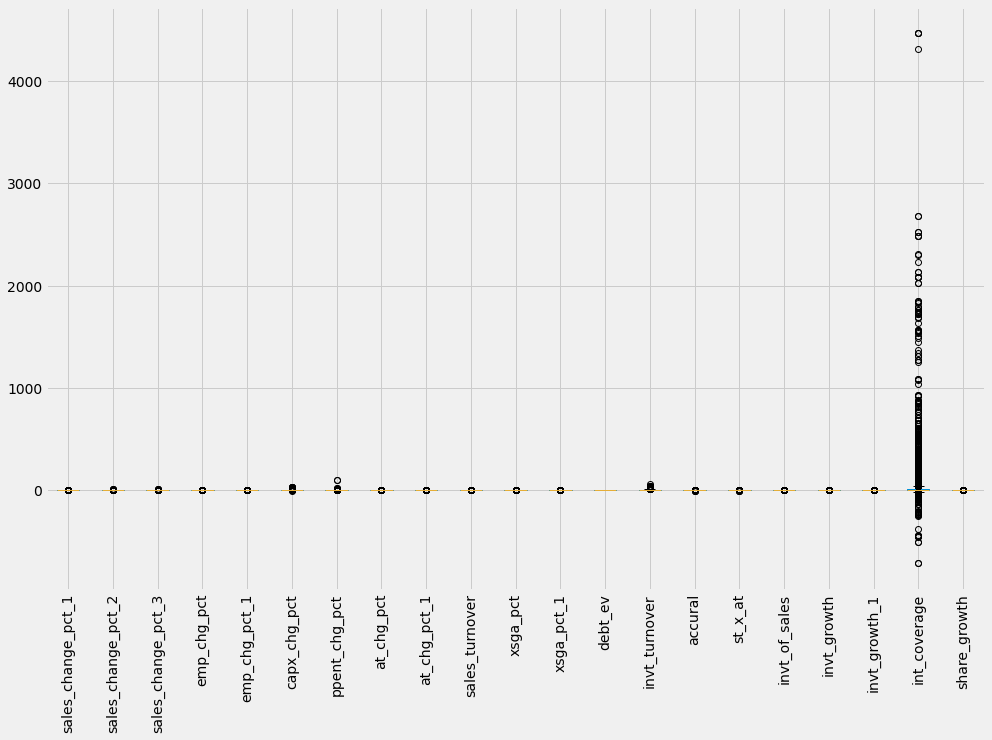

In [7]:
def winsorize_series(series:pd.Series):
    q = series.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        series[series < q.iloc[0]] = q.iloc[0]
        series[series > q.iloc[1]] = q.iloc[1]

    return series

df_winsored = df.copy()
df_winsored['shifted_year'] = df.date_shifted.dt.year

df_master = pd.DataFrame() # Data frame that we w

for year in df_winsored.shifted_year.unique():
    df_filtered = df_winsored[df_winsored.shifted_year == year]
    temp_df = pd.DataFrame()

    temp_df[identifier_cols] = df_filtered[identifier_cols]
    temp_df[dependent_col] = df_filtered[dependent_col]
    for c in independent_vars:
        temp_df[c] = winsorize_series(df_filtered[c])
        
    df_master = df_master.append(temp_df)


df_master = df_master.sort_values(['gvkey','datadate'])
plt.figure(figsize = (15,10))
df_master[independent_vars].boxplot(rot = 90)
df_master.head(3)

Dropping extreme sales values because again we want to focus on the "normal".

In [8]:
quantiles = df_master['sales_change_pct'].quantile([.05,.95])
df_trimmed = df_master[(df_master.sales_change_pct > quantiles.values[0]) & (df_master.sales_change_pct < quantiles.values[1])].copy()
print(df_trimmed.shape)
df_trimmed.head(2)

(3899, 25)


,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
7827,001104,1998-12-31,1999-06-30,-0.21572,-0.01780,-0.10420,-0.01010,0.12760,-0.20988,0.70627,...,-0.12009,0.53878,2.70728,0.11924,0.14822,0.30427,0.35083,-0.42131,1.33861,-0.00767
7519,001104,1999-12-31,2000-06-30,-0.09380,-0.21572,-0.01780,-0.10420,-0.27945,0.12760,-0.13761,...,-0.10546,0.76121,2.01455,-0.07870,-0.04061,0.36394,-0.05774,0.35083,0.25899,0.00446


## EDA

In [9]:
df_eda = df_trimmed[identifier_cols + dependent_col + independent_vars].copy()

In [10]:
# for col in independent_vars:
#     sns.scatterplot(data=df_eda,x=col,y='sales_change_pct')
#     plt.show()

,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,ppent_chg_pct,at_chg_pct,at_chg_pct_1,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
sales_change_pct,1.00000,0.21793,0.08923,0.07067,0.20877,0.09312,0.04280,-0.00991,0.25214,0.07797,...,0.05721,-0.27081,-0.03677,0.15927,0.25524,0.04240,0.18875,0.05533,0.08318,-0.01219
sales_change_pct_1,0.21793,1.00000,0.19479,0.06863,0.37749,0.29197,0.12285,0.10512,0.40748,0.35121,...,0.23055,-0.17081,0.04975,0.30894,0.43498,-0.00819,0.39838,0.28791,0.09009,-0.32299
sales_change_pct_2,0.08923,0.19479,1.00000,0.09442,0.21195,0.31058,0.04103,0.00357,0.19409,0.44875,...,0.52548,-0.07099,0.02680,0.11795,0.19800,0.00780,0.12239,0.40334,0.04754,-0.07832
sales_change_pct_3,0.07067,0.06863,0.09442,1.00000,0.03386,0.06104,-0.05904,-0.03427,0.06676,0.11350,...,0.14408,-0.02267,-0.03532,0.03899,0.06929,0.00590,0.01252,0.10645,0.02394,-0.04721
emp_chg_pct,0.20877,0.37749,0.21195,0.03386,1.00000,0.10815,0.18379,0.23940,0.53204,0.22421,...,0.12768,-0.12710,0.06440,0.13837,0.48657,0.00298,0.46208,0.10753,0.05802,0.06361
emp_chg_pct_1,0.09312,0.29197,0.31058,0.06104,0.10815,1.00000,0.06241,0.01926,0.19667,0.53849,...,0.46573,-0.04406,0.01364,0.06126,0.17885,0.00642,0.13282,0.47831,0.01670,0.00526
capx_chg_pct,0.04280,0.12285,0.04103,-0.05904,0.18379,0.06241,1.00000,0.34780,0.24989,0.11570,...,0.02848,-0.04643,0.10566,0.07364,0.21240,0.07242,0.19521,0.04688,0.02530,0.11870
ppent_chg_pct,-0.00991,0.10512,0.00357,-0.03427,0.23940,0.01926,0.34780,1.00000,0.18919,0.07914,...,0.02718,-0.01003,0.01438,0.00929,0.13751,0.05701,0.14268,0.00813,0.00202,0.03929
at_chg_pct,0.25214,0.40748,0.19409,0.06676,0.53204,0.19667,0.24989,0.18919,1.00000,0.25915,...,0.19065,-0.17536,0.08647,0.31050,0.86403,0.04104,0.66080,0.15595,0.06440,0.20226
at_chg_pct_1,0.07797,0.35121,0.44875,0.11350,0.22421,0.53849,0.11570,0.07914,0.25915,1.00000,...,0.61140,-0.06246,0.04812,0.11368,0.24289,0.01287,0.23188,0.66587,0.04011,-0.01355


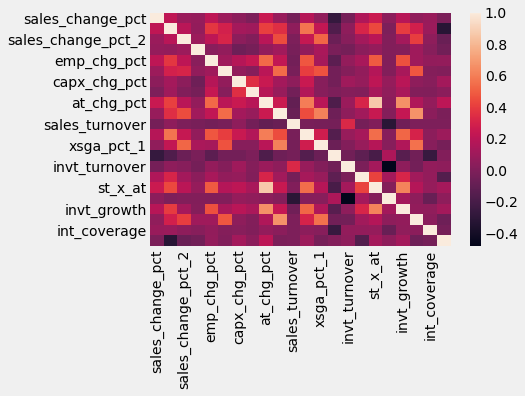

In [11]:
corr_matrix =  df_eda[dependent_col+independent_vars].corr()
sns.heatmap(corr_matrix)
corr_matrix

### Sanity check models
Can we do good if we cheat and evaluate the models in sample?

In [12]:
model = smf.ols(formula=f'sales_change_pct ~ {" + ".join(independent_vars)}',data=df_eda).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       sales_change_pct   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     32.65
Date:                Mon, 14 Feb 2022   Prob (F-statistic):          2.00e-120
Time:                        15:26:13   Log-Likelihood:                 2141.0
No. Observations:                3899   AIC:                            -4238.
Df Residuals:                    3877   BIC:                            -4100.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0826      0

In [13]:
# rf = RandomForestRegressor()
# rf.fit(df_eda[independent_vars],df_eda[dependent_col])
# print(rf.score(df_eda[independent_vars],df_eda[dependent_col]))
# print(rf.predict(df_eda[independent_vars]))

# tree_model = DecisionTreeRegressor(max_depth=4)
# tree_model.fit(df_eda[independent_vars],df_eda[dependent_col])
# print(tree_model.score(df_eda[independent_vars],df_eda[dependent_col]))
# print(tree_model.predict(df_eda[independent_vars]))

# from matplotlib.pyplot import figure
# figure(figsize=(15, 8), dpi=80)
# tree.plot_tree(tree_model);

## Modeling

In [14]:
from sklearn.pipeline import Pipeline
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso())])

def train_lasso(df,lookback_years=10):
    """Return lasso trained model"""

    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    # xtrain_df= pd.DataFrame(scaler.fit_transform(np.array(xtrain_df)))

    #Setting the alpha (lambda) values and the 5-split KFold
    alpha_values = 10**np.linspace(.1,-4,13)
    # alpha_values = [0]
    kfold_cv = KFold(n_splits = 5)
    MSE_cv_lasso = pd.DataFrame(columns = alpha_values)

    #Looping through the 5-Fold Split for Cross Validation
    for train_index, test_index in kfold_cv.split(xtrain_df):
        X_train_cv, X_test_cv = xtrain_df.iloc[train_index], xtrain_df.iloc[test_index]
        y_train_cv, y_test_cv = np.array(ytrain_df)[train_index], np.array(ytrain_df)[test_index]
        MSE_values_lasso = []
        
        # Looping through all the Alpha (Lambda) values
        for i in range(len(alpha_values)):
            # lasso_model = Lasso(alpha = alpha_values[i])
            # lasso_model.fit(X_train_cv,y_train_cv)
            lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=alpha_values[i]))])
            lasso_pipe.fit(X_train_cv,y_train_cv)
            lasso_pred = lasso_pipe.predict(X_test_cv)
            MSE_values_lasso.append(mean_squared_error(y_test_cv,lasso_pred))

        MSE_cv_lasso.loc[len(MSE_cv_lasso)] = MSE_values_lasso 

    # Calculating minimum Alpha (Lambda) Value
    lasso_min_alpha = MSE_cv_lasso.mean(axis=0).idxmin()
    lasso_min_mse = MSE_cv_lasso.mean(axis=0).min()

    # lasso_model_final = Lasso(alpha = lasso_min_alpha)
    # lasso_model_final.fit(xtrain_df,ytrain_df)
    lasso_pipe_final = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=lasso_min_alpha))])
    lasso_pipe_final.fit(xtrain_df,ytrain_df)
    return lasso_pipe_final

# lasso = train_lasso(df_trimmed)
# lasso.score(df_trimmed[independent_vars],df_trimmed[dependent_col])

In [15]:
from sklearn.model_selection import GridSearchCV

def train_ols(df,lookback_years=10):
    """Return ols trained model"""
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    lm = LinearRegression().fit(xtrain_df, ytrain_df)
    return lm

def train_tree(df, lookback_years=10) -> float:
    """Return decision tree trained model"""
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    
    params_grid = {'max_depth':list(range(2,15))}

    best_params = GridSearchCV(estimator=DecisionTreeRegressor(),param_grid=params_grid).fit(xtrain_df,ytrain_df).best_params_
    best_tree_model = DecisionTreeRegressor(**best_params).fit(xtrain_df,ytrain_df)

    return best_tree_model

def train_rf(df, lookback_years=10) -> float:
    """Return rf trained model"""
    
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]

    params_grid = {'max_depth':[3,4,5],
                   'max_features':['auto','sqrt','log']}

    best_params = GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_grid).fit(xtrain_df,ytrain_df).best_params_
    best_rf_model = RandomForestRegressor(**best_params).fit(xtrain_df,ytrain_df)

    return best_rf_model

def predict_model(df,model):
    """Send in an sklearn model that implements the 'predict' function and the output is an array of y_hats"""
    X_df = df[independent_vars]
    y_hats = model.predict(X_df)
    return y_hats

Let's clean up our data frame to only contain the relevant columns.

In [16]:
# df_modeling = df_master[identifier_cols + dependent_col + independent_vars].copy()
df_modeling = df_trimmed[identifier_cols + dependent_col + independent_vars].copy()
display(df_modeling.head(1))
display(df_modeling.describe())

,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
7827,001104,1998-12-31,1999-06-30,-0.21572,-0.01780,-0.10420,-0.01010,0.12760,-0.20988,0.70627,...,-0.12009,0.53878,2.70728,0.11924,0.14822,0.30427,0.35083,-0.42131,1.33861,-0.00767


,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,ppent_chg_pct,at_chg_pct,at_chg_pct_1,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
count,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,...,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000,3899.00000
mean,0.02188,0.04697,0.06361,0.07110,0.03836,0.06243,0.39816,0.15875,0.07031,0.09423,...,0.08852,0.43833,4.43900,-0.05626,0.08131,0.22389,0.07813,0.09393,59.09549,0.03010
std,0.15160,0.23124,0.30975,0.34670,0.31584,0.36353,2.00159,2.41423,0.27398,0.32764,...,0.25423,0.23709,3.44800,0.14950,0.36573,0.19696,0.32832,0.33638,272.23107,0.20482
min,-0.40128,-0.88962,-0.90041,-0.96044,-0.74573,-0.74046,-1.00000,-0.97093,-0.63352,-0.60358,...,-0.55713,0.01822,0.48367,-1.88147,-2.27090,0.00134,-0.86037,-0.87131,-714.76286,-0.48547
25%,-0.07074,-0.05957,-0.05252,-0.05471,-0.07143,-0.06370,-0.28084,-0.08279,-0.05239,-0.04563,...,-0.03313,0.24808,2.54123,-0.08987,-0.06354,0.12609,-0.08752,-0.08394,2.43094,-0.00785
50%,0.02813,0.03921,0.04493,0.04769,0.00714,0.01400,0.01715,0.00696,0.03039,0.03814,...,0.05252,0.41494,3.65879,-0.04027,0.03479,0.17089,0.04219,0.05029,6.81286,0.00224
75%,0.11988,0.14137,0.15490,0.15800,0.09459,0.10592,0.39766,0.13154,0.13160,0.14720,...,0.15627,0.60819,5.14679,0.00635,0.17369,0.24163,0.18244,0.20249,18.07788,0.01565
max,0.39421,2.01200,7.69769,8.06334,5.72052,5.94512,31.80033,103.02393,2.78638,3.52538,...,2.84231,0.99765,41.61992,0.31914,3.88057,1.86737,3.65574,2.56284,4466.72592,6.02747


This is the heart of it. Loop through every data row between 2011 and 2020 (inclusive) and predict sales using both lasso and OLS. Then attach the predictions to their respective rows in the df_preds dataframe.

**Note: Takes like 5 minute seconds to run probaly.**

In [17]:
all_lasso_coefs = pd.DataFrame(columns=independent_vars)
rf_importances = pd.DataFrame(columns=independent_vars)

df_preds = pd.DataFrame() # Data fram to hold results

for year in range(2010,2020):
# for year in range(2010,2012):
    prediction_date = pd.to_datetime(f'{str(year)}-12-31') # Prediction date is 12/31 each year.
    df_filtered = df_modeling[df_modeling.date_shifted <= prediction_date] # Only use data available on that date!
    ols_model = train_ols(df_filtered)
    lasso_pipe = train_lasso(df_filtered)
    all_lasso_coefs.loc[year] = (lasso_pipe['lasso'].coef_) # We need to access the lasso model like a dictionary from the pipeline
    tree_model = train_tree(df_filtered)
    rf_model = train_rf(df_filtered)
    rf_importances.loc[year] = rf_model.feature_importances_ 
    
    # ---- Now predict --------
    # The prediciton data frame will be every data point that is "released" in the year after prediction date.
    df_to_predict = df_modeling[df_modeling.date_shifted.dt.year == (prediction_date.year+1)]

    df_to_predict['yhat_base'] = df_filtered.sales_change_pct.mean() # Base model is the historical average growth rate of the industry
    # df_to_predict['yhat_base'] = df_to_predict[['sales_change_pct_1','sales_change_pct_2','sales_change_pct_3']].mean(axis=1).values
    df_to_predict['yhat_ols'] = predict_model(df_to_predict,ols_model)
    df_to_predict['yhat_lasso'] = predict_model(df_to_predict,lasso_pipe)
    df_to_predict['yhat_tree'] = predict_model(df_to_predict,tree_model)
    df_to_predict['yhat_random_forest'] = predict_model(df_to_predict, rf_model)
    
    df_preds = df_preds.append(df_to_predict)

df_preds.head(2)

,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth,yhat_base,yhat_ols,yhat_lasso,yhat_tree,yhat_random_forest
2654,001104,2010-12-31,2011-06-30,0.09859,-0.08884,0.15612,0.09877,-0.02190,0.08730,-0.23688,...,0.29417,-0.20070,0.14967,25.45161,-0.05534,0.01588,0.01703,0.00976,0.01254,0.00223
2701,001397,2010-12-31,2011-06-30,-0.34501,-0.17907,-0.10846,-0.03401,-0.15385,-0.13333,-0.34642,...,0.20087,-0.21786,0.00869,1.59832,0.00000,0.01588,-0.08474,-0.07467,-0.06023,-0.06883


In [2]:
# df_preds.head(10)

## Evaluate Models

In [18]:
def calc_metrics(df:pd.DataFrame, y_hat_col_names:list, y_col_name:str='sales_change_pct') -> float:
    """Function to calculat metrics on each model's predictions."""
    results = pd.DataFrame(columns=y_hat_col_names,index=['R^2','RMSE','MAE','Max_Resid'])
    for y_hat_col in y_hat_col_names:
        residuals = (df[y_col_name] - df[y_hat_col])
        sse = (residuals**2).sum()
        sst = (df[y_col_name].var()) * (len(df)-1) 

        r_square = 1 - sse/sst
        mae = np.mean(np.abs(residuals))
        rmse = np.mean(sse)**.5
        max_resid = np.max(residuals)
        results.loc[['R^2','RMSE','MAE','Max_Resid'],y_hat_col] = [r_square, rmse, mae,max_resid]

    return results

metrics = calc_metrics(df_preds,['yhat_base','yhat_ols','yhat_lasso','yhat_tree','yhat_random_forest'])
metrics

,yhat_base,yhat_ols,yhat_lasso,yhat_tree,yhat_random_forest
R^2,-0.01262,0.05716,0.12443,0.12102,0.14553
RMSE,5.12605,4.94627,4.76653,4.77582,4.70877
MAE,0.10745,0.09800,0.09722,0.09846,0.09617
Max_Resid,0.37302,0.98953,0.44771,0.40713,0.44039


We can also group our errors by year and examine the performance that way.

In [19]:
df_preds['pred_year'] = df_preds['date_shifted'].dt.year
yearly_metrics = pd.DataFrame()

groupy = df_preds.groupby('pred_year')
for year, mini_df in groupy:
    metrics = calc_metrics(mini_df,['yhat_base','yhat_ols','yhat_lasso','yhat_tree','yhat_random_forest'])
    yearly_metrics[year] = metrics.stack()

yearly_metrics = yearly_metrics.T
yearly_metrics

R^2                                                       RMSE  \
     yhat_base yhat_ols yhat_lasso yhat_tree yhat_random_forest yhat_base   
2011  -0.01381  0.13970    0.14077   0.05085            0.12820   1.88072   
2012  -0.03341  0.23222    0.20371   0.10238            0.18431   1.93086   
2013  -0.01364 -0.53963    0.10479   0.01525            0.00772   1.69011   
2014  -0.00839  0.03385    0.07259   0.15649            0.17699   1.74416   
2015  -0.00109  0.12745    0.13591   0.16111            0.21225   1.63545   
2016  -0.00948  0.24582    0.21738   0.32994            0.24950   1.46046   
2017  -0.00029 -0.10656   -0.09581   0.07101            0.00992   1.37188   
2018  -0.12411  0.06037    0.06294  -0.00946            0.11618   1.32347   
2019  -0.04025  0.23425    0.19479   0.22884            0.23621   1.56845   
2020  -0.01208  0.01185    0.02031   0.02177            0.00572   1.48700   

                                                            MAE           \
     yhat_ols yhat_lasso yhat_tree yhat_random_forest yhat_base yhat_ols   
2011  1.73250    1.73141   1.81976            1.74403   0.11871  0.10692   
2012  1.66430    1.69492   1.79953            1.71544   0.12758  0.10949   
2013  2.08296    1.58831   1.66585            1.67220   0.10629  0.10852   
2014  1.70724    1.67266   1.59521            1.57570   0.11794  0.10912   
2015  1.52686    1.51943   1.49712            1.45076   0.11012  0.10112   
2016  1.26235    1.28593   1.18986            1.25926   0.09450  0.08242   
2017  1.44292    1.43589   1.32208            1.36486   0.09379  0.09236   
2018  1.21001    1.20835   1.25417            1.17353   0.08981  0.08019   
2019  1.34569    1.37992   1.35043            1.34396   0.10866  0.09046   
2020  1.46932    1.46301   1.46192            1.47387   0.09883  0.09207   

                                             Max_Resid                      \
     yhat_lasso yhat_tree yhat_random_forest yhat_base yhat_ols yhat_lasso   
2011    0.10879   0.11604            0.10990   0.35625  0.38585    0.33942   
2012    0.11168   0.11711            0.11151   0.36060  0.40932    0.40948   
2013    0.09515   0.09912            0.09918   0.36760  0.98953    0.31273   
2014    0.10902   0.10751            0.10555   0.37302  0.55211    0.44771   
2015    0.10078   0.09931            0.09508   0.33094  0.30416    0.29585   
2016    0.08370   0.08019            0.08335   0.31373  0.25813    0.26868   
2017    0.09194   0.08488            0.08850   0.30667  0.37709    0.37915   
2018    0.08045   0.08526            0.07718   0.31350  0.30116    0.29070   
2019    0.09294   0.09332            0.09002   0.35100  0.30282    0.30580   
2020    0.09121   0.09255            0.09339   0.35033  0.35493    0.34377   

                                   
     yhat_tree yhat_random_forest  
2011   0.35960            0.36740  
2012   0.40713            0.44039  
2013   0.36802            0.36822  
2014   0.34372            0.32104  
2015   0.30651            0.30217  
2016   0.28564            0.25549  
2017   0.38964            0.39441  
2018   0.32341            0.29582  
2019   0.26480            0.32381  
2020   0.33407            0.32694

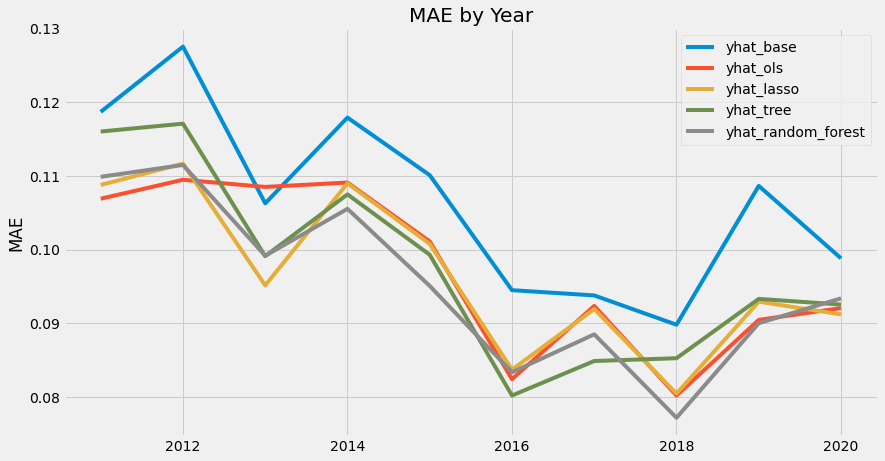

In [20]:
yearly_metrics['MAE'].plot(figsize=(13,7))
plt.title('MAE by Year')
plt.ylabel('MAE')
plt.show()

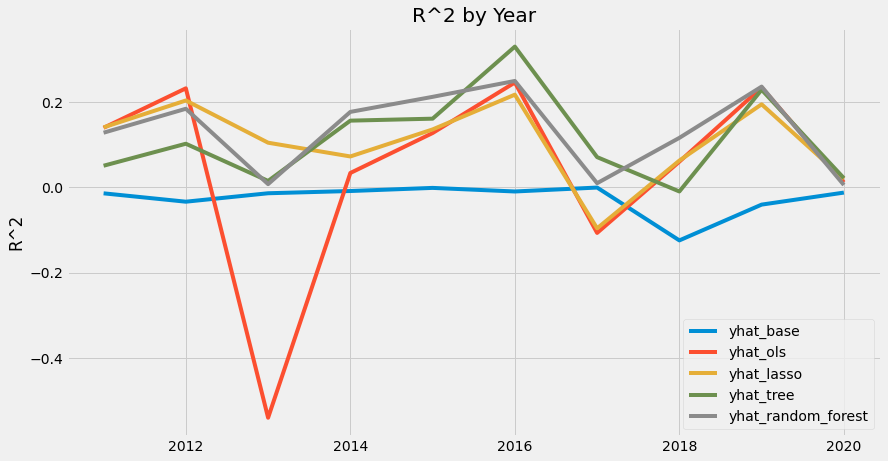

In [21]:
yearly_metrics['R^2'].plot(figsize=(13,7))
plt.title('R^2 by Year')
plt.ylabel('R^2')
plt.show()

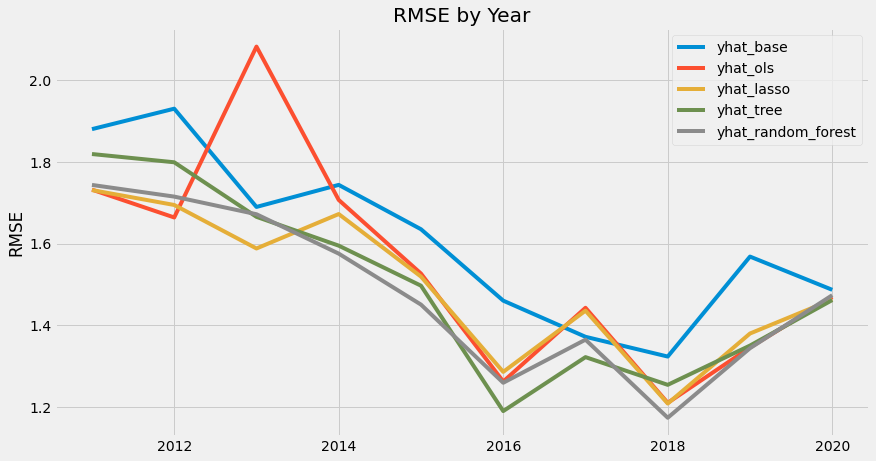

In [22]:
yearly_metrics['RMSE'].plot(figsize=(13,7))
plt.title('RMSE by Year')
plt.ylabel('RMSE')
plt.show()

Examining the lasso coefficients

,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,ppent_chg_pct,at_chg_pct,at_chg_pct_1,sales_turnover,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
2010,0.00943,-0.00000,0.00000,0.00736,0.00030,0.00000,-0.00000,0.01905,-0.00000,-0.00000,...,-0.00000,-0.03170,-0.00244,0.00512,0.00351,0.00000,0.00000,-0.00000,0.00000,-0.00000
2011,0.00848,-0.00000,0.00254,0.01019,0.00498,-0.00000,-0.00222,0.01837,-0.00000,-0.00158,...,-0.00291,-0.03561,-0.00403,0.00681,0.00438,0.00000,0.00000,-0.00143,0.00000,-0.00000
2012,0.00893,-0.00000,0.00334,0.01007,0.00487,-0.00000,-0.00239,0.01986,-0.00000,-0.00101,...,-0.00331,-0.03620,-0.00390,0.00682,0.00380,-0.00000,0.00000,-0.00247,0.00000,-0.00173
2013,0.00849,-0.00000,0.00196,0.01117,0.00478,-0.00000,-0.00791,0.01733,-0.00000,-0.00129,...,-0.00392,-0.03500,-0.00733,0.00712,0.00580,0.00000,0.00000,-0.00148,0.00000,-0.00332
2014,0.00980,-0.00000,0.00201,0.01094,0.00343,-0.00000,-0.00782,0.01530,-0.00000,-0.00220,...,-0.00279,-0.03504,-0.00665,0.00689,0.00554,0.00000,0.00104,-0.00157,0.00000,-0.00000
2015,0.00879,-0.00000,0.00233,0.01085,0.00339,0.00000,-0.00769,0.01550,-0.00000,-0.00212,...,-0.00247,-0.03442,-0.00743,0.00599,0.00605,0.00000,0.00204,-0.00118,0.00000,-0.00000
2016,0.00911,0.00000,0.00308,0.01102,0.00349,-0.00000,-0.00767,0.01700,-0.00000,-0.00179,...,-0.00197,-0.03457,-0.00624,0.00637,0.00421,0.00158,0.00144,-0.00131,0.00000,-0.00000
2017,0.01050,0.00000,0.00398,0.01083,0.00284,-0.00000,-0.00756,0.01349,-0.00001,-0.00166,...,-0.00204,-0.03306,-0.00593,0.00581,0.00777,0.00227,0.00000,-0.00043,0.00008,-0.00000
2018,0.00956,0.00000,0.00391,0.01097,0.00286,-0.00000,-0.00742,0.01286,-0.00003,-0.00145,...,-0.00189,-0.03331,-0.00556,0.00577,0.00848,0.00283,0.00000,-0.00036,0.00000,0.00000
2019,0.01062,0.00000,0.00407,0.01162,0.00243,-0.00000,-0.00753,0.01261,-0.00021,-0.00177,...,-0.00144,-0.03321,-0.00522,0.00514,0.00830,0.00467,0.00000,-0.00059,0.00000,0.00000


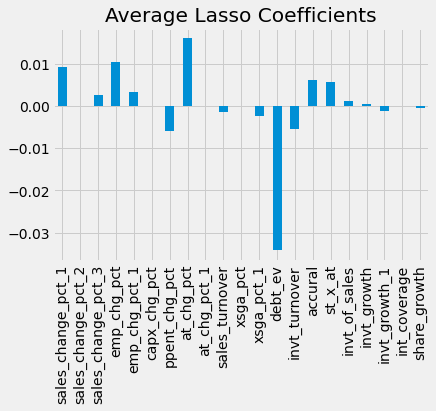

In [23]:
display(all_lasso_coefs)
all_lasso_coefs.mean().plot(kind='bar')
plt.title('Average Lasso Coefficients');
# all_lasso_coefs.plot(figsize=(17,7))
# plt.title('Lasso Coefficients by Year');

,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,ppent_chg_pct,at_chg_pct,at_chg_pct_1,sales_turnover,...,xsga_pct_1,debt_ev,invt_turnover,accural,st_x_at,invt_of_sales,invt_growth,invt_growth_1,int_coverage,share_growth
2010,0.01668,0.02534,0.01755,0.30094,0.02220,0.01472,0.03132,0.13409,0.01258,0.02307,...,0.01763,0.12517,0.01810,0.04013,0.05389,0.02235,0.01781,0.01232,0.06668,0.01777
2011,0.01274,0.02300,0.02082,0.27408,0.02936,0.01376,0.02362,0.12439,0.01203,0.01594,...,0.02195,0.14420,0.01652,0.04209,0.07288,0.02542,0.01713,0.01279,0.07151,0.01494
2012,0.01561,0.01904,0.01513,0.25043,0.02589,0.01084,0.03117,0.12969,0.01280,0.01922,...,0.01688,0.16622,0.01600,0.04376,0.10008,0.01858,0.01596,0.01093,0.05104,0.02106
2013,0.01471,0.01984,0.01966,0.28045,0.02278,0.01420,0.02597,0.11215,0.01081,0.01615,...,0.02286,0.15518,0.01618,0.04881,0.09462,0.02095,0.01820,0.00982,0.04964,0.01770
2014,0.00842,0.01162,0.00566,0.36972,0.01963,0.00677,0.01591,0.11494,0.00541,0.00876,...,0.00943,0.17319,0.01349,0.03934,0.08977,0.01155,0.01329,0.00693,0.06289,0.00910
2015,0.01221,0.01383,0.00621,0.34344,0.01976,0.00714,0.02076,0.15418,0.00652,0.01013,...,0.01162,0.15833,0.01318,0.03777,0.07660,0.01245,0.01281,0.00834,0.06033,0.00935
2016,0.01708,0.01675,0.01448,0.29358,0.02056,0.01011,0.02772,0.12609,0.01100,0.01296,...,0.02155,0.14662,0.01894,0.05342,0.07433,0.02060,0.01830,0.00924,0.06244,0.01341
2017,0.01997,0.01798,0.01254,0.29547,0.01979,0.01427,0.02066,0.14280,0.01464,0.01649,...,0.01660,0.14547,0.02146,0.04101,0.05643,0.02047,0.01737,0.01031,0.07286,0.01442
2018,0.01721,0.01603,0.01562,0.29166,0.02886,0.01052,0.02212,0.13428,0.01088,0.01490,...,0.01981,0.14392,0.02206,0.03619,0.07115,0.02320,0.01466,0.00678,0.07297,0.01624
2019,0.01962,0.02199,0.01484,0.31496,0.02578,0.01249,0.02406,0.12614,0.00909,0.01721,...,0.01911,0.13327,0.02654,0.03707,0.05815,0.02245,0.01743,0.00788,0.06865,0.01264


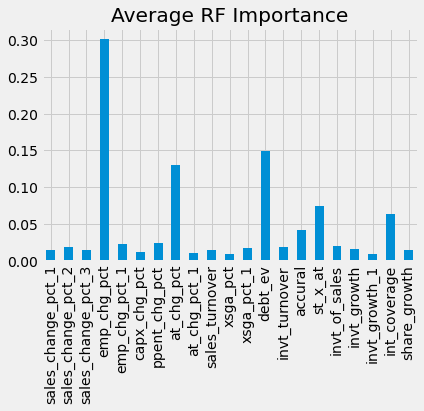

In [24]:
display(rf_importances)
rf_importances.mean().plot(kind='bar')
plt.title('Average RF Importance');


## Sorted Portfolios

### Incorporating Returns:

Bring in fama french data:

In [25]:
french_df_monthly = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/french_monthly.csv?raw=true')

# Convert date to datetime and add new columns for year and month.
french_df_monthly['date'] = pd.to_datetime(french_df_monthly.date,format='%Y%m')
french_df_monthly = french_df_monthly.set_index('date')
french_df_monthly['year'] = french_df_monthly.index.year
french_df_monthly['month'] = french_df_monthly.index.month

french_df_monthly['mkt'] = french_df_monthly['Mkt-RF'] + french_df_monthly['RF']

# Making this dataframe multi-indexed by year and month makes working with the other return dataframes later on much easier
french_df_monthly = french_df_monthly.set_index(keys=['year','month']) 

# Convert the data from percents to decimal representation
french_df_monthly = french_df_monthly/100 
french_df_monthly.head()

Mkt-RF      SMB      HML      RF      mkt
year month                                            
1926 7      0.02960 -0.02380 -0.02730 0.00220  0.03180
     8      0.02640 -0.01470  0.04140 0.00250  0.02890
     9      0.00360 -0.01390  0.00120 0.00230  0.00590
     10    -0.03240 -0.00130  0.00650 0.00320 -0.02920
     11     0.02530 -0.00160 -0.00380 0.00310  0.02840

Grab returns for all companies, we are examining and store it in a dataframe for easy lookup later on.

[Stock Return Data Source](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-monthly/)

In the below cell: trt1m is the total return for the month  with dividends re-invested.

In [26]:
db = wrds.Connection(wrds_username='iarzt')

Loading library list...
Done


In [27]:
relevant_gv_keys = convert_to_sql(df_preds.gvkey.unique())
query_string = f"""SELECT gvkey, datadate, prccm, trt1m from comp.secm where gvkey IN({relevant_gv_keys}) and datadate between '01/01/1996' and '01/01/2021' order by datadate desc"""
df_rets = db.raw_sql(query_string)
df_rets['trt1m'] = df_rets['trt1m']/100 # Convert to decimal
df_rets['datadate'] = pd.to_datetime(df_rets.datadate)
df_rets['year'] = df_rets.datadate.dt.year
df_rets['month'] = df_rets.datadate.dt.month
df_rets['ret_factor'] = df_rets.trt1m + 1
df_rets

,gvkey,datadate,prccm,trt1m,year,month,ret_factor
0,006669,2020-12-31,76.23000,0.00488,2020,12,1.00488
1,011060,2020-12-31,85.41000,0.02998,2020,12,1.02998
2,010016,2020-12-31,111.84000,0.00684,2020,12,1.00684
3,111486,2020-12-31,35.59000,0.04800,2020,12,1.04800
4,011632,2020-12-31,3.90000,0.02362,2020,12,1.02362
...,...,...,...,...,...,...,...
59240,024978,1996-01-31,21.62500,-0.04420,1996,1,0.95580
59241,011465,1996-01-31,54.37500,0.02113,1996,1,1.02113
59242,008229,1996-01-31,2.37500,0.00000,1996,1,1.00000
59243,012459,1996-01-31,10.37500,0.03750,1996,1,1.03750


In [28]:
# Returns for all gvkeys in our period.
rets_piv = pd.pivot_table(data=df_rets,columns='gvkey',index=['year','month'],values='trt1m')
rets_piv.head()

gvkey        001104   001397   001408   001468   001906   002061   002080  \
year month                                                                  
1996 1      0.00000 -0.05747  0.02528 -0.01357 -0.05357 -0.12179  0.05376   
     2      0.00000 -0.00610  0.00548  0.01046  0.02642 -0.08029  0.05918   
     3     -0.06452 -0.06871 -0.06336  0.00913  0.17647  0.09524  0.00971   
     4     -0.13793  0.03311 -0.02059  0.00000 -0.03750  0.00000 -0.00962   
     5      0.20000  0.01923  0.06306 -0.01231 -0.09091  0.14493 -0.01650   

gvkey        002271   002436   002444  ...  186208  186240  186345  187163  \
year month                             ...                                   
1996 1      0.03533 -0.03509 -0.05729  ...     NaN     NaN     NaN     NaN   
     2      0.03269 -0.10000  0.01657  ...     NaN     NaN     NaN     NaN   
     3      0.02593  0.11111  0.00546  ...     NaN     NaN     NaN     NaN   
     4     -0.00775  0.18519 -0.04348  ...     NaN     NaN     NaN     NaN   
     5      0.07460  0.07813  0.02273  ...     NaN     NaN     NaN     NaN   

gvkey       198058  200595  206956  224604  258869  271841  
year month                                                  
1996 1         NaN     NaN     NaN     NaN     NaN     NaN  
     2         NaN     NaN     NaN     NaN     NaN     NaN  
     3         NaN     NaN     NaN     NaN     NaN     NaN  
     4         NaN     NaN     NaN     NaN     NaN     NaN  
     5         NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 237 columns]

Merge fama french with stock returns:

In [29]:
total_rets = french_df_monthly.merge(rets_piv, left_index=True, right_index=True)
total_rets_factors = total_rets + 1
total_rets_factors.head(2)

Mkt-RF     SMB     HML      RF     mkt  001104  001397  001408  \
year month                                                                   
1996 1     1.02260 0.97270 1.00400 1.00430 1.02690 1.00000 0.94253 1.02528   
     2     1.01330 1.01780 0.98930 1.00390 1.01720 1.00000 0.99390 1.00548   

            001468  001906  ...  186208  186240  186345  187163  198058  \
year month                  ...                                           
1996 1     0.98643 0.94643  ...     NaN     NaN     NaN     NaN     NaN   
     2     1.01046 1.02642  ...     NaN     NaN     NaN     NaN     NaN   

            200595  206956  224604  258869  271841  
year month                                          
1996 1         NaN     NaN     NaN     NaN     NaN  
     2         NaN     NaN     NaN     NaN     NaN  

[2 rows x 242 columns]

Below few cells are again messy, but we are jsut trying to attach monthly returns to each year and merge that onto our predictions.

In [30]:
total_rets_factors = total_rets + 1
total_rets_factors.head(2)

Mkt-RF     SMB     HML      RF     mkt  001104  001397  001408  \
year month                                                                   
1996 1     1.02260 0.97270 1.00400 1.00430 1.02690 1.00000 0.94253 1.02528   
     2     1.01330 1.01780 0.98930 1.00390 1.01720 1.00000 0.99390 1.00548   

            001468  001906  ...  186208  186240  186345  187163  198058  \
year month                  ...                                           
1996 1     0.98643 0.94643  ...     NaN     NaN     NaN     NaN     NaN   
     2     1.01046 1.02642  ...     NaN     NaN     NaN     NaN     NaN   

            200595  206956  224604  258869  271841  
year month                                          
1996 1         NaN     NaN     NaN     NaN     NaN  
     2         NaN     NaN     NaN     NaN     NaN  

[2 rows x 242 columns]

In [31]:
# Aggregate monthly returns to yearly
total_rets_factors_yearly = total_rets_factors.groupby('year').prod() - 1
total_rets_factors_yearly.head(3)

,Mkt-RF,SMB,HML,RF,mkt,001104,001397,001408,001468,001906,...,186208,186240,186345,187163,198058,200595,206956,224604,258869,271841
year,,,,,,,,,,,,,,,,,,,,,
1996,0.15232,-0.03799,0.06240,0.05200,0.21158,0.41935,0.04313,0.16646,0.05240,-0.08571,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1997,0.24783,-0.06731,0.14917,0.05252,0.31214,0.09091,0.09717,0.13708,0.40737,-0.11134,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1998,0.18621,-0.19574,-0.09817,0.04855,0.24327,-0.62500,-0.13034,-0.12530,0.06791,-0.43735,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [32]:
mergey = pd.DataFrame(total_rets_factors_yearly.stack())
mergey.columns = ['year_return']

mergey.index.names = ['ret_year','gvkey']
mergey = mergey.reset_index()
mergey.head(7)

,ret_year,gvkey,year_return
0,1996,Mkt-RF,0.15232
1,1996,SMB,-0.03799
2,1996,HML,0.06240
3,1996,RF,0.05200
4,1996,mkt,0.21158
5,1996,001104,0.41935
6,1996,001397,0.04313


In [33]:
mergey.sort_values(by='year_return',ascending=False)

,ret_year,gvkey,year_return
5739,2019,066448,399.00000
1880,2003,123434,68.33333
5784,2019,177465,59.00000
5546,2018,179457,53.26250
1360,2001,030169,43.00000
...,...,...,...
5229,2017,029627,-0.99516
5995,2020,125863,-0.99570
5688,2019,023577,-0.99800
4413,2014,009289,-0.99877


Below cell calculates our "sorting variable".

In [34]:
mergey['year_return'].quantile([.05,.95])

0.05000   -0.62435
0.95000    1.12972
Name: year_return, dtype: float64

In [35]:
mergy_quantiles = mergey['year_return'].quantile([.01,.99])
mergey_trimmed = mergey[(mergey.year_return > mergy_quantiles.values[0]) & (mergey.year_return < mergy_quantiles.values[1])].copy()
mergey_trimmed.shape

(5928, 3)

In [36]:
df_preds['trade_year'] = df_preds['pred_year'] - 1

df_ret_calcs = df_preds.copy()
port_labels = ['p_1','p_2','p_3','p_4','p_5']
df_ret_calcs['port_label'] = df_preds.groupby('trade_year')['yhat_random_forest'].transform(lambda x: pd.qcut(x, 5, labels=port_labels))
df_ret_calcs.head(3)

,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,int_coverage,share_growth,yhat_base,yhat_ols,yhat_lasso,yhat_tree,yhat_random_forest,pred_year,trade_year,port_label
2654,001104,2010-12-31,2011-06-30,0.09859,-0.08884,0.15612,0.09877,-0.02190,0.08730,-0.23688,...,25.45161,-0.05534,0.01588,0.01703,0.00976,0.01254,0.00223,2011,2010,p_3
2701,001397,2010-12-31,2011-06-30,-0.34501,-0.17907,-0.10846,-0.03401,-0.15385,-0.13333,-0.34642,...,1.59832,0.00000,0.01588,-0.08474,-0.07467,-0.06023,-0.06883,2011,2010,p_1
2572,001408,2010-12-31,2011-06-30,0.03977,-0.12866,-0.09521,-0.03727,-0.10524,-0.12657,-0.10664,...,4.49907,0.00234,0.01588,-0.00034,-0.00501,-0.06023,-0.04069,2011,2010,p_2


In [37]:
df_ret_calcs = df_ret_calcs.merge(mergey_trimmed,left_on=['gvkey','pred_year'],right_on=['gvkey','ret_year'])
# df_ret_calcs['return_year'] = df_ret_calcs.trade_year + 1
df_ret_calcs.head()

,gvkey,datadate,date_shifted,sales_change_pct,sales_change_pct_1,sales_change_pct_2,sales_change_pct_3,emp_chg_pct,emp_chg_pct_1,capx_chg_pct,...,yhat_base,yhat_ols,yhat_lasso,yhat_tree,yhat_random_forest,pred_year,trade_year,port_label,ret_year,year_return
0,001104,2010-12-31,2011-06-30,0.09859,-0.08884,0.15612,0.09877,-0.02190,0.08730,-0.23688,...,0.01588,0.01703,0.00976,0.01254,0.00223,2011,2010,p_3,2011,0.02398
1,001397,2010-12-31,2011-06-30,-0.34501,-0.17907,-0.10846,-0.03401,-0.15385,-0.13333,-0.34642,...,0.01588,-0.08474,-0.07467,-0.06023,-0.06883,2011,2010,p_1,2011,-0.31624
2,001408,2010-12-31,2011-06-30,0.03977,-0.12866,-0.09521,-0.03727,-0.10524,-0.12657,-0.10664,...,0.01588,-0.00034,-0.00501,-0.06023,-0.04069,2011,2010,p_2,2011,0.07378
3,001468,2011-02-28,2011-08-28,-0.04880,-0.00643,0.14463,0.15118,-0.02256,-0.02564,-0.52362,...,0.01588,0.01611,0.00500,-0.06023,-0.01862,2011,2010,p_2,2011,-0.41591
4,001906,2010-12-31,2011-06-30,-0.27019,-0.44498,-0.46325,-0.61276,-0.04898,-0.23676,-0.96199,...,0.01588,-0.00696,-0.00559,-0.06023,-0.01764,2011,2010,p_3,2011,-0.63774


In [38]:
df_ret_calcs.groupby(['ret_year','port_label'])[['year_return']].count().mean()

year_return   26.46000
dtype: float64

In [39]:
df_port_ret = df_ret_calcs.groupby(['port_label','ret_year'])[['year_return']].mean()
df_port_ret = df_port_ret.reset_index().pivot(index = 'ret_year', columns = 'port_label')
df_port_ret

year_return                                    
port_label         p_1      p_2      p_3      p_4      p_5
ret_year                                                  
2011          -0.08565 -0.16002 -0.10418 -0.02658 -0.09404
2012           0.37761  0.33153  0.46206  0.19592  0.14294
2013           0.23177  0.39383  0.32344  0.44284  0.40398
2014           0.04512  0.06657  0.10293 -0.03849 -0.11786
2015          -0.12762 -0.07581  0.00891  0.01129 -0.07911
2016           0.52442  0.11967  0.12231  0.07440  0.19723
2017          -0.04187  0.20121  0.13039  0.19815  0.16210
2018          -0.05447 -0.15367 -0.20159 -0.10563 -0.25438
2019           0.01448  0.16131  0.11335  0.13199  0.28424
2020           0.69520  0.01534  0.20583  0.44115  0.25404

In [40]:
df_ret_calcs.groupby(['port_label'])[['year_return']].mean()

,year_return
port_label,
p_1,0.15073
p_2,0.09139
p_3,0.12253
p_4,0.13209
p_5,0.09106


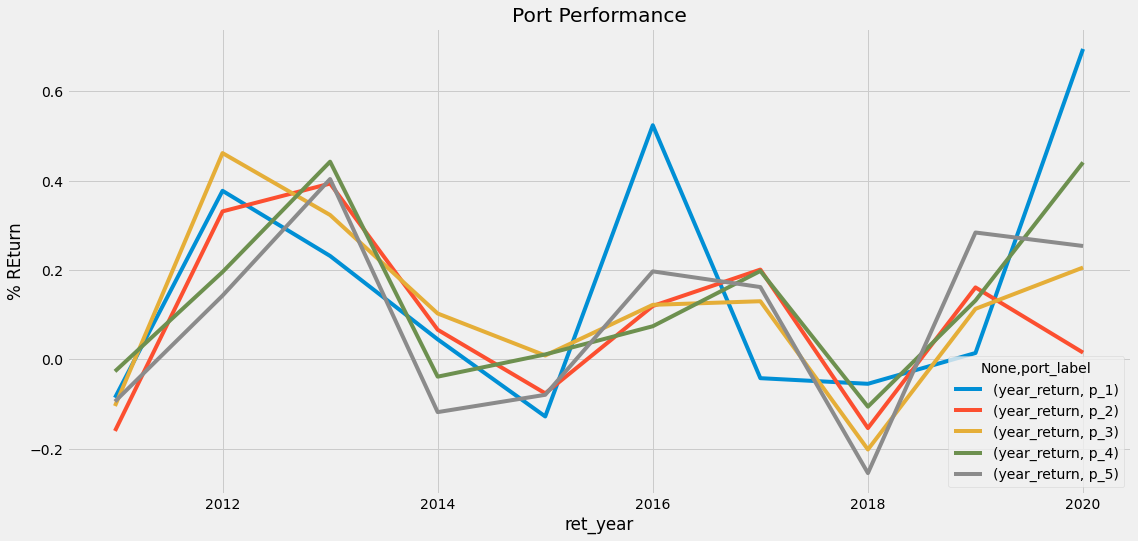

In [41]:
df_port_ret.plot(figsize=(17,8))
plt.title('Port Performance')
plt.ylabel('% REturn');

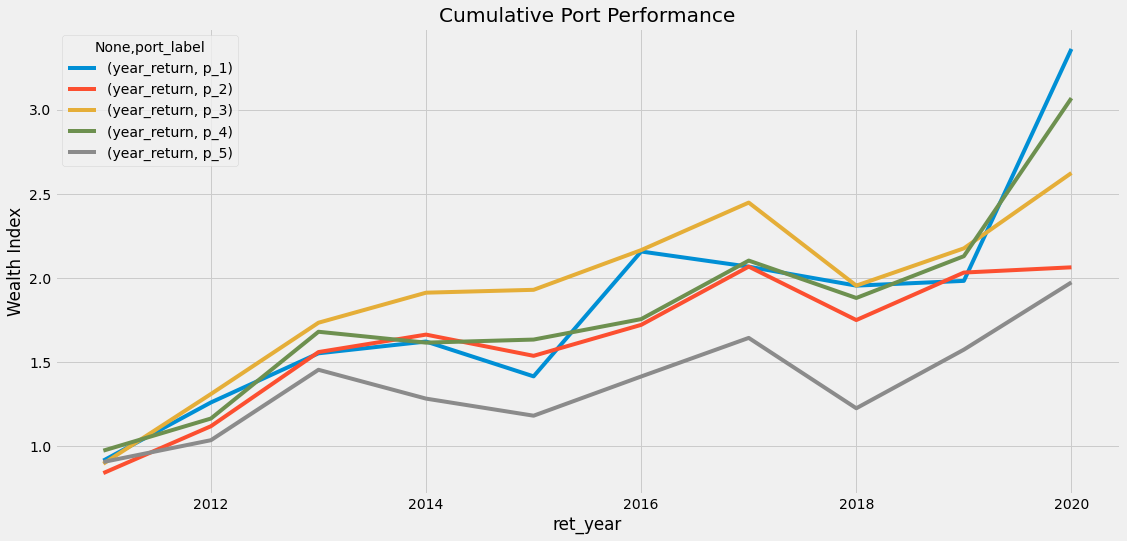

In [42]:
(df_port_ret+1).cumprod().plot(figsize=(17,8))
plt.title('Cumulative Port Performance')
plt.ylabel('Wealth Index');